# REAL TIME USB WEBCAM OUTPUT

## Prepare the Overlay
Load the DPU overlay onto the board.

In [1]:
from pynq_dpu import DpuOverlay
overlay = DpuOverlay("dpu.bit")
overlay.load_model("dpu_tf_yolov3.elf")

## Libraries, Constants, Helper Functions
View all of the helper functions here: [DNNDK yolo example](https://github.com/Xilinx/Vitis-AI/blob/v1.1/mpsoc/vitis_ai_dnndk_samples/tf_yolov3_voc_py/tf_yolov3_voc.py). 

The helper functions released along with Vitis AI cover pre-processing of 
the images, so they can be normalized and resized to be compatible with 
the DPU model. These functions are included in our `pynq_dpu` package.

In [2]:
# Import the required modules for real-time camera output
import cv2
import time
import numpy as np
import PIL.Image
from io import BytesIO
import IPython.display
import ipywidgets as widgets
import threading
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt

import random
import colorsys
from PIL import Image
from matplotlib.patches import Rectangle
%matplotlib inline
from pynq_dpu.edge.dnndk.tf_yolov3_voc_py.tf_yolov3_voc import *

In [3]:
# Constants and Helpers for DPU

# Use predefined anchors for yolo
anchor_list = [10,13,16,30,33,23,30,61,62,45,59,119,116,90,156,198,373,326]
anchor_float = [float(x) for x in anchor_list]
anchors = np.array(anchor_float).reshape(-1, 2)

# Get Classes
classes_path = "img/voc_classes.txt"
class_names = get_class(classes_path)

# Generate unique color for each class
num_classes = len(class_names)
hsv_tuples = [(1.0 * x / num_classes, 1., 1.) for x in range(num_classes)]
colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
colors = list(map(lambda x: 
                  (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), 
                  colors))
random.seed(0)
random.shuffle(colors)
random.seed(None)

# define DPU-related Parameters, such as DPU kernel name and node names
KERNEL_CONV="tf_yolov3"
CONV_INPUT_NODE="conv2d_1_convolution"
CONV_OUTPUT_NODE1="conv2d_59_convolution"
CONV_OUTPUT_NODE2="conv2d_67_convolution"
CONV_OUTPUT_NODE3="conv2d_75_convolution"

In [4]:
# Helpers for accessing cameras etc.

#Use 'jpeg' instead of 'png' (~5 times faster)
def showarray(a, prev_display_id=None, fmt='jpeg'):
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    obj = IPython.display.Image(data=f.getvalue())
    if prev_display_id is not None:
        IPython.display.update_display(obj, display_id=prev_display_id)
        return prev_display_id
    else:
        return IPython.display.display(obj, display_id=True)
    
def get_frame(cam):
    # Capture frame-by-frame
    ret, frame = cam.read()
    
    return frame

In [5]:
def get_camera_indexes(max=5):
    # ref: https://stackoverflow.com/a/53310665/3553367
    arr = []
    for index in range(0, max):
#         print(index)
        cap = cv2.VideoCapture()
        cap.open(index)
        if cap.isOpened():
            arr.append(index)
        cap.release()
    return arr
# Get Available Cameras.
camera_indexes = get_camera_indexes()
print("Camera Indices:", camera_indexes)

Camera Indices: [0]


In [6]:
def init_cam():
    cam = cv2.VideoCapture(0)
    cam.set(cv2.CAP_PROP_FRAME_WIDTH, 416)
    cam.set(cv2.CAP_PROP_FRAME_HEIGHT, 416)
    print("Camera Initiated: ", cam.get(3), cam.get(4))
    return {'cam': cam, 'displayid': None}
    
webcam = init_cam()

Camera Initiated:  352.0 288.0


## DPU Application
Create DPU kernel and task

In [7]:
n2cube.dpuOpen()
kernel = n2cube.dpuLoadKernel(KERNEL_CONV)
task = n2cube.dpuCreateTask(kernel, 0)

In [8]:
# Function for running DPU application on image_data
def DPUClassify(task, image_data):
    input_len = n2cube.dpuGetInputTensorSize(task, CONV_INPUT_NODE)
    n2cube.dpuSetInputTensorInHWCFP32(task, CONV_INPUT_NODE, image_data, input_len)

    n2cube.dpuRunTask(task)

    conv_sbbox_size = n2cube.dpuGetOutputTensorSize(task, CONV_OUTPUT_NODE1)
    conv_out1 = n2cube.dpuGetOutputTensorInHWCFP32(task, CONV_OUTPUT_NODE1, 
                                                   conv_sbbox_size)
    conv_out1 = np.reshape(conv_out1, (1, 13, 13, 75))

    conv_mbbox_size = n2cube.dpuGetOutputTensorSize(task, CONV_OUTPUT_NODE2)
    conv_out2 = n2cube.dpuGetOutputTensorInHWCFP32(task, CONV_OUTPUT_NODE2, 
                                                   conv_mbbox_size)
    conv_out2 = np.reshape(conv_out2, (1, 26, 26, 75))

    conv_lbbox_size = n2cube.dpuGetOutputTensorSize(task, CONV_OUTPUT_NODE3)
    conv_out3 = n2cube.dpuGetOutputTensorInHWCFP32(task, CONV_OUTPUT_NODE3, 
                                                   conv_lbbox_size)
    conv_out3 = np.reshape(conv_out3, (1, 52, 52, 75))

    yolo_outputs = [conv_out1, conv_out2, conv_out3]    
    
    return yolo_outputs

Output()

FloatProgress(value=0.0, max=1.0)

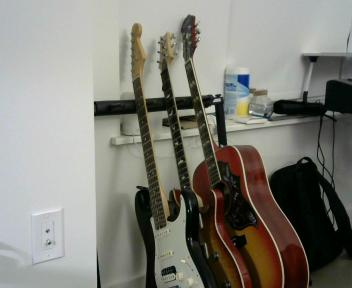

In [6]:
### Display real-time webcam feed
# Reference; real-time display

totalFrames = 300
captureImg = False

fps_output = widgets.Output()
display(fps_output)

progress = widgets.FloatProgress(value=0.0, min=0.0, max=1.0)

curFrameNum = 0

def work(progress):
    while curFrameNum <= totalFrames:
        time.sleep(1)
        progress.value = curFrameNum / totalFrames
        
progressThread = threading.Thread(target=work, args=(progress,))
display(progress)
progressThread.start()

for curFrame in range(1, totalFrames+1):
    curFrameNum = curFrame
    t1 = time.time()
    
    # Captuer Frame
    frame = get_frame(webcam.get("cam"))
    
    # Convert the image from OpenCV BGR format to matplotlib RGB format
    # to display the image
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    displayid = webcam.get('displayid')
    if displayid is not None:
        showarray(frame, displayid)
    else:
        display_handle = showarray(frame)
        webcam['displayid'] = display_handle.display_id
            
    t2 = time.time()
            
    with fps_output:
        print("Frame: %d of %d" % (curFrame, totalFrames))
        print("%f FPS" % (1/(t2-t1)))
        # Display the frame info until new frame is available
        IPython.display.clear_output(wait=True)
        

webcam.get("cam").release()

Time Elapsed: 2.9454257488250732


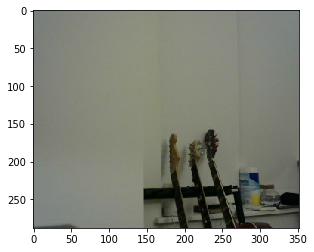

In [7]:
webcam.get("cam").release()
imgshow = None

t1 = time.time()
IPython.display.clear_output(wait=False)
savePath = 'img/camCap.jpg'
!fswebcam --no-banner --save {savePath} -d /dev/video0 2> /dev/null

image_path = savePath
image = cv2.imread(image_path)

_, ax = plt.subplots(1)
if imgshow == None:
    imgshow = ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

t2 = time.time()
print("Time Elapsed:", t2-t1)

### Save image from camera using fswebcam
```python
savePath = 'img/camCap.jpg'
%time !fswebcam --no-banner --save {savePath} -d /dev/video0 2> /dev/null

image_path = savePath
image = cv2.imread(image_path)
_, ax = plt.subplots(1)
_ = ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
```